<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/IFR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESTRATÉGIA
1.   IFR para 2 períodos < 5 compra na abertura seguinte
2.   Preço fechamento > ma5 vende na abertura seguinte



In [1]:
# @ Data é ano/mes/dia.

inicio  = '2020-01-02'  #@param {type:"date"}
termino = '2023-01-30'  #@param {type:"date"}
from datetime import datetime

usar_periodo = True #@param {type:"boolean"}
periodo = '1y' #@param ['1d','5d','1mo','3mo','6mo','1y','2y','3y','5y','10y','ytd','max']

In [2]:
# @ markdown Instala bibliotecas

import pandas as pd
import numpy as np

# import pyfolio as pf
# import quantstats as qstats
# import pandas_ta as pta

# !pip install -q  yfinance
import yfinance as yf

import cufflinks as cf
cf.go_offline()


# import plotly.io as pio
# pio.renderers.default = 'png'  ## comentar se quiser grafico interativo

In [4]:
arq = 'data/Cart_Ibov.csv'
# arq = 'data/Cart_IBr100.csv'
try:
    IBOV = pd.read_csv(arq, sep=';' , encoding='latin1', skiprows=1, skipfooter=2, engine='python')
except:
    url = f'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/{arq}'
    IBOV = pd.read_csv(url, encoding='utf-8', sep=';' ,index_col=False ,engine='python')



In [5]:
IBOV.reset_index(inplace=True)

In [6]:
codigos = np.array(sorted(IBOV['index'].to_list()),dtype=str) 
tickers = [tk+'.SA' for tk in codigos]
tickers[50]

'MULT3.SA'

In [7]:
# @ markdown ## download dados do yahoo finance
## a ultima lina da tabela tem a data mais recente
df=pd.DataFrame()
if usar_periodo : 
  df = yf.download(tickers, period = periodo   , auto_adjust=True, progress = False )[['Open','Close']]
else: 
  df = yf.download(tickers, start = inicio , end = termino , auto_adjust=True, progress = False )[['Open','Close']]

d = dict(zip(df.columns.levels[1],df.columns.levels[1].str.rstrip('.SA') ))
df = df.rename(columns=d, level=1)

df.columns = [" ".join(col).strip() for col in df.columns.values]
df.head(1) #mostra a primeiro linha da tabela dos preços

,Open ABEV3,Open ALOS3,Open ASAI3,Open AURE3,Open AZZA3,Open B3SA3,Open BBAS3,Open BBDC3,Open BBDC4,Open BBSE3,...,Close TOTS3,Close UGPA3,Close USIM5,Close VALE3,Close VAMO3,Close VBBR3,Close VIVA3,Close VIVT3,Close WEGE3,Close YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-04,10.654867,21.060338,10.64661,12.208306,50.576626,10.368366,25.517205,10.252027,11.288249,31.817242,...,28.953667,21.639791,8.15,58.770576,8.344596,20.605345,22.42,22.321119,41.197083,11.242692


In [28]:
#  Calcula o IFR para todos os ativos da carteira
#  O IFR é calculado com uma média móvel de 2 períodos, mas pode ser ajustado conforme necessário.
#  O resultado é um DataFrame com o IFR de cada ativo, onde cada coluna corresponde a um ativo e cada linha a um período de tempo.
#  O resultado pode ser salvo em um arquivo CSV, se desejado.
def rsi(price, window=2, output: str = None):   
    '''
    Calcula o IFR (Índice de Força Relativa)
    - price: série de preços
    - window: período da média móvel (default: 2)
    - output: se fornecido, salva o DataFrame em CSV com esse nome
    '''
    
    data = pd.DataFrame(price).copy()
    data["Variation"] = data.diff()

    data["Gain"] = np.where(data["Variation"] > 0, data["Variation"], 0)
    data["Loss"] = np.where(data["Variation"] < 0, data["Variation"], 0)

    data['avg_gain'] = data["Gain"].rolling(window, min_periods=window).mean()
    data['avg_loss'] = data["Loss"].abs().rolling(window, min_periods=window).mean()

    # Corrigido: evitar chained assignment
    for i in range(window, len(data)):
        data.loc[data.index[i], 'avg_gain'] = (
            data.loc[data.index[i - 1], 'avg_gain'] * (window - 1) + data.loc[data.index[i], "Gain"]
        ) / window
        data.loc[data.index[i], 'avg_loss'] = (
            data.loc[data.index[i - 1], 'avg_loss'] * (window - 1) + data.loc[data.index[i], "Loss"].__abs__()
        ) / window

    data['rsi'] = 100 - (100 / (1 + (data['avg_gain'] / data['avg_loss']))).round(2)

    if output is not None:
        data.to_csv(output)

    return data['rsi']


**lista os ativos do índice com ifr2 < 5**


In [16]:
limiar_ifr=5.25

In [30]:
IFR = pd.DataFrame({f"{i}": rsi( df['Close '+i] , 2)  for i in codigos})
IFR

,ABEV3,ALOS3,ASAI3,AURE3,AZZA3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,...,TOTS3,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVA3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-05,0.00,100.00,100.00,NaN,100.00,0.00,0.00,100.00,100.00,100.00,...,0.00,100.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00
2024-07-08,0.00,46.67,100.00,0.00,100.00,85.00,0.00,100.00,100.00,100.00,...,82.47,100.00,0.00,0.00,58.14,77.50,26.87,100.00,100.00,100.00
2024-07-09,0.00,68.50,56.52,92.31,100.00,50.00,0.00,100.00,100.00,100.00,...,82.47,100.00,60.00,0.00,82.52,88.16,69.18,100.00,100.00,100.00
2024-07-10,81.63,27.97,27.66,94.12,75.42,78.21,70.69,100.00,100.00,100.00,...,94.70,100.00,33.33,0.00,92.71,95.21,34.48,100.00,56.43,48.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,61.50,93.51,94.19,86.22,90.02,98.47,93.19,89.87,92.60,91.65,...,76.65,87.89,34.28,76.29,27.11,77.36,94.60,83.82,67.80,65.32
2025-07-01,71.36,96.65,27.21,50.25,40.08,78.49,57.19,94.24,96.08,97.03,...,84.15,92.52,24.70,89.66,18.32,85.15,94.84,91.58,45.90,75.68
2025-07-02,91.33,24.77,6.42,12.29,21.23,62.61,68.13,35.30,32.83,70.91,...,32.14,52.44,89.47,97.47,8.27,31.81,40.43,94.81,39.51,25.72


In [32]:
print('o ultimo preço é do dia',IFR.index[-1].day,'/',IFR.index[-1].month,'/',IFR.index[-1].year)
print('Os ativos com IFR<5 são:')
## seleciona os ativos dentre 'codigos' com ifr2 < 5 
lista_ifr=[]
for x in codigos :
  if IFR[x].iloc[-1]< limiar_ifr :  
    print(x)
    lista_ifr.append(x)

if len(lista_ifr)==0: print(F'*************** Não tem papel com IFR<{limiar_ifr} ***************')

o ultimo preço é do dia 4 / 7 / 2025
Os ativos com IFR<5 são:
NATU3


**histórico da estratégia**

In [38]:
# @ markdown Simula as operações
def trades (x):
  '''
  'trades' cria duas listas 'entrada' e 'saida' 
  essas listas têm 3 componentes: 
    a linha na tabela de dados do sinal de entrada/saida;
    a data seguinte do sinal (entrada/saida), que é o dia de negociação, e 
    o preço (open) de entrada/saida naquele dia, preço da negociação
  '''
  open  = 'Open '+x
  close = 'Close '+x

  bt = df[[open , close]].copy() 
  #media movel simples de 5 periodos 
  bt['mm5'] = df[close].rolling(5).mean()  
  bt['ifr'] = IFR[x]
  bt=bt.dropna()
  
  ## marca todos os pontos com ifr2 < 5
  bt['sinal_entra'] = np.where(bt['ifr'] < 5 , 1 , 0)
  #marca todos pontos com close > mm5
  bt['sinal_sai'] = np.where(bt[close] > bt['mm5'] , -1 , 0)

  '''
  cria listas com os pontos de entrada e saída das operações
  1) percorre a tabela bt em ordem cronológica até achar sinal entrada
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de abertura do dia seguinte
  2) em seguida, continua, a partir do proximo dia, até achar sinal saida
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de fechamento do dia seguinte
  3) repete os passos 1 e 2 
  '''  
  entrada = []
  saida = []
  i=0
  while i < len(bt):
    while  i < len(bt) and bt['sinal_entra'].iloc[i] == 0 : i+=1 # pega um sinal de entrada
    if i+1 < len(bt) :                          # se teve pregão dia seguinte,entra
        i+=1                                    # vai p/ dia seguinte
        entrada.append( ( i-1,                                      # sinal no dia anterior
                         bt.index[i].date().strftime("%d/%m/%Y") ,  # dia entrada
                         np.round(bt[open].iloc[i],2)))             # preço entrada
       #avança até o primeiro sinal de saída, que pode ser no proprio dia
        while (i < len(bt) and bt['sinal_sai'].iloc[i]==0) : i=i+1    
       #se teve pregão dia seguinte,sai  (senão vai dormir comprado, vamos desconsiderar)
        if i+1 < len(bt) :  
            i+=1                                                        # vai p/ dia seguinte
            saida.append( (i-1,                                         # sinal no dia anterior
                           bt.index[i].date().strftime("%d/%m/%Y")  ,   # dia saida
                           np.round(bt[open].iloc[i],2)) )              # preço saida
            # senão, a ultima operação ainda não deu saida , remove ultima entrada
        else : entrada.pop()                    
    i=i+1
  return entrada,saida

In [ ]:
# @ markdown Mostra os resultados

resumo = pd.DataFrame(index=lista_ifr,columns=[ \
    'IFR2',                    # ifr do papel
    'Operações' ,              # no. de operações no periodo
    'Positivas' ,     # no. de operações com retorno >0
    'Tx acerto' ,              # Retornos positivos / Retornos 
    'Acumulado',               # Retorno acumulado pela estratégia 
    'Ret. médio pos' ,          # média aritmetica dos retornos > 0
    'Ret. médio neg' ,          # média aritmetica dos retornos < 0
    'Exp matematica',
    'Duração média(dias)' ])   # no. medio de dias que fica posicionado

# usando as informações da função 'trades', simula as operações
# calcula o tempo de cada operação e a variação do preço do ativo

out =  [ [[],[]] for j in range(len(lista_ifr))] 
retornos = [ [[],[]] for j in range(len(lista_ifr))] 
z=0
for x in lista_ifr:
  dura = []  ## duração da operação, em dias uteis
  e    = []  ## pontos de entrada 
  s    = []  ## pontos de saida
  posret = 0 ## conta retornos positivos

  e,s = trades(x)
  # mensagens para ajudar na validação
  out1 =  ['' for j in range(len(e))] # entrada/saida
  out2 =  ['' for j in range(len(e))] # duração
  out3 =  ['' for j in range(len(e))] # retorno
  
  for j in range(len(e)) :
      out1[j] =  "entrada em " + str(e[j][1]) + " e saida em " + str(s[j][1]) 
      
      dias = s[j][0] - e[j][0]
      out2[j] = " durou "+str(dias)+" dias e "
      dura.append(dias)

      retorno = s[j][2]/e[j][2] - 1
      out3[j] = "variou "+str(round(retorno*100,3))+"%" 
      retornos[z][1].append(retorno)
      if retorno > 0 : posret +=1
  
  if len(retornos[z][1])!=0 : wins = np.round(posret/(len(retornos[z][1])),3) 
  else : wins = 0
  retpos = np.round(np.mean([r for r in retornos[z][1] if r > 0]), 2) if any(r > 0 for r in retornos[z][1]) else 0
  retneg = abs(np.round(np.mean([r for r in retornos[z][1] if r <= 0]), 2)) if any(r <= 0 for r in retornos[z][1]) else 0
#
 # retpos = np.round(np.mean([x for x in retornos[z][1] if x>0]),2)
 # retneg = abs(np.round(np.mean([x for x in retornos[z][1] if x<=0]),2))
#
  expectativa = (wins * retpos) - ((1 - wins) * retneg)

  resumo.loc[x] = [ IFR[x].iloc[-1].round(2) if not IFR[x].empty else np.nan,
#IFR[x].iloc[-1].round(2), 
                   len(e) , 
                   posret , 
                   wins,
                   np.round((np.array(retornos[z][1])+1).cumprod()[-1] - 1,2) , 
                   retpos, 
                   retneg,
                   expectativa*100, 
                   np.round(np.mean(dura),1) 
                   ]
  
  retornos[z][0] = x
  out[z][0] = x
  for j in range(len(e)) : 
        out[z][1].append(out1[j] + out2[j]+out3[j])        
  z=z+1

resumo = resumo.sort_values(by=['Exp matematica'], ascending=False)
display(resumo)#.sort_values(by=['Exp matematica'], ascending=False))

In [44]:
resumo = pd.DataFrame(index=lista_ifr, columns=[
    'IFR2', 'Operações', 'Positivas', 'Tx acerto',
    'Acumulado', 'Ret. médio pos', 'Ret. médio neg',
    'Exp matematica', 'Duração média(dias)'
])

out = [[[], []] for _ in range(len(lista_ifr))]
retornos = [[[], []] for _ in range(len(lista_ifr))]

z = 0
for x in lista_ifr:
    dura = []
    e, s = trades(x)
    posret = 0

    out1, out2, out3 = [''] * len(e), [''] * len(e), [''] * len(e)

    for j in range(len(e)):
        out1[j] = f"entrada em {e[j][1]} e saida em {s[j][1]}"
        dias = s[j][0] - e[j][0]
        out2[j] = f" durou {dias} dias e "
        dura.append(dias)

        retorno = s[j][2] / e[j][2] - 1
        out3[j] = f"variou {round(retorno * 100, 3)}%"
        retornos[z][1].append(retorno)
        if retorno > 0:
            posret += 1

    ret_list = retornos[z][1]
    wins = round(posret / len(ret_list), 3) if ret_list else 0
    retpos = round(np.mean([r for r in ret_list if r > 0]), 2) if any(r > 0 for r in ret_list) else 0
    retneg = abs(round(np.mean([r for r in ret_list if r <= 0]), 2)) if any(r <= 0 for r in ret_list) else 0
    expectativa = (wins * retpos) - ((1 - wins) * retneg)
    acumulado = round((np.array(ret_list) + 1).cumprod()[-1] - 1, 2) if ret_list else 0

    resumo.loc[x] = [
        IFR[x].iloc[-1].round(2) if not IFR[x].empty else np.nan,
        len(e),
        posret,
        wins,
        acumulado,
        retpos,
        retneg,
        round(expectativa * 100, 2),
        round(np.mean(dura), 1) if dura else 0
    ]

    retornos[z][0] = x
    out[z][0] = x
    for j in range(len(e)):
        out[z][1].append(out1[j] + out2[j] + out3[j])
    z += 1

resumo = resumo.sort_values(by='Exp matematica', ascending=False)
display(resumo)


,IFR2,Operações,Positivas,Tx acerto,Acumulado,Ret. médio pos,Ret. médio neg,Exp matematica,Duração média(dias)
NATU3,0.0,0,0,0,0,0,0,0,0


analise 1º ativo da lista

In [ ]:
ativo = resumo.index[0]
print('bt de ',ativo)

bt de  B3SA3


In [ ]:
entrada,saida = trades(ativo)
entra = [datetime.strptime(x[1] , "%d/%m/%Y") for x in entrada]
sai   = [datetime.strptime(x[1] , "%d/%m/%Y") for x in saida]

In [ ]:
posicao = pd.DataFrame(columns=['pos'], index=df.index)
posicao.loc[entra] = 1
posicao.loc[sai] = 0
posicao.ffill(inplace=True)
posicao.fillna(0,inplace=True)
# posicao.iplot()

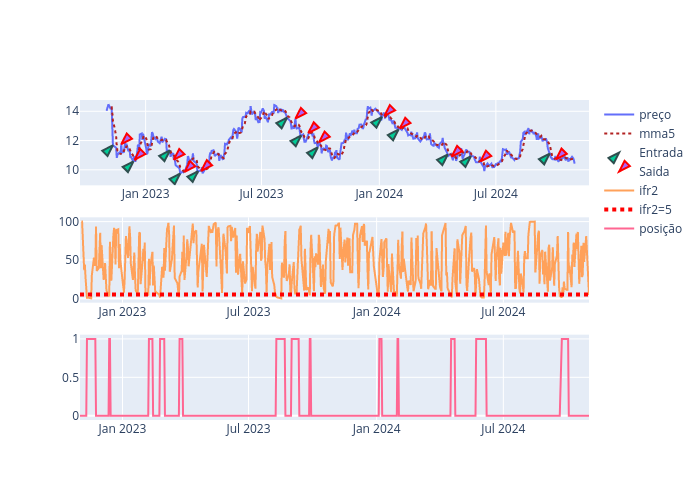

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df['Close '+ativo].rolling(5).mean() 


fig = make_subplots(rows=3, cols=1) #go.Figure()
fig.add_trace(go.Scatter(x = df.index , y = df['Close '+ativo].values , name="preço"),1,1)
fig.add_trace(go.Scatter(x = df.index , y =  df['Close '+ativo].rolling(5).mean(), mode='lines', 
                         line=dict(color='firebrick', width=2, dash='dot'), name="mma5"),1,1)

fig.add_trace(go.Scatter(x = df.loc[entra].index, y = df.loc[entra]['Close '+ativo] , mode='markers' ,name='Entrada',
                             marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey"))
                         ),1,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.add_trace(go.Scatter(x = df.loc[sai].index, y = df.loc[sai]['Close '+ativo] , mode='markers' ,name='Saida',
                         marker=dict(size=12, symbol="arrow", angle=-135, line=dict(width=2, color="red"))
                         ),1,1)
fig.add_trace(go.Scatter(x = df.index , y = IFR[ativo].values , name="ifr2"),2,1)
fig.add_trace(go.Scatter(x = df.index , y = [5]*len(df.index) , name="ifr2=5", mode='lines', 
              line=dict(color='red', width=4, dash='dot')),2,1)

fig.add_trace(go.Scatter(x =posicao.index , y = posicao['pos'] , mode='lines', name="posição"),3,1)


fig.show()

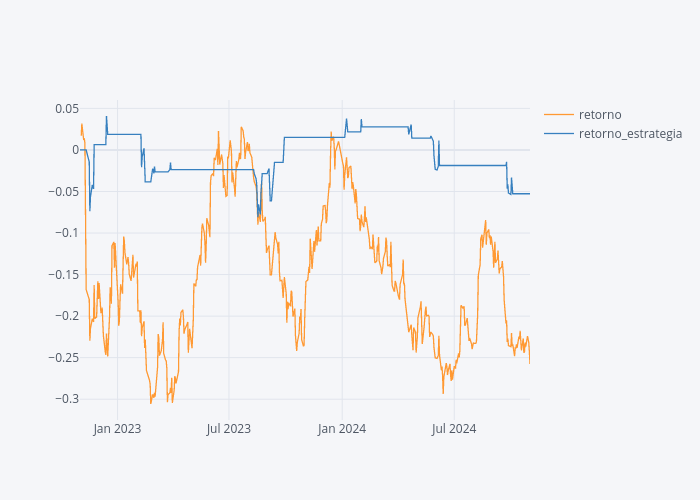

In [ ]:
ohlc = yf.download(tickers= ativo+'.SA', period = periodo , auto_adjust=True, progress = False )
ohlc['retorno'] = ohlc['Close'].pct_change()
## calculating stretegy returns
ohlc['retorno_estrategia'] = ohlc['retorno'] * (posicao['pos'].shift(1))
# ohlc.fillna(0,inplace=True)
ohlc['retorno_estrategia'].fillna(0,inplace=True)
ohlc[ohlc['retorno_estrategia']!= 0.0]
((ohlc[['retorno', 'retorno_estrategia']]+1).cumprod()-1).iplot();

In [ ]:
retorno_estrategia=ohlc['retorno_estrategia']

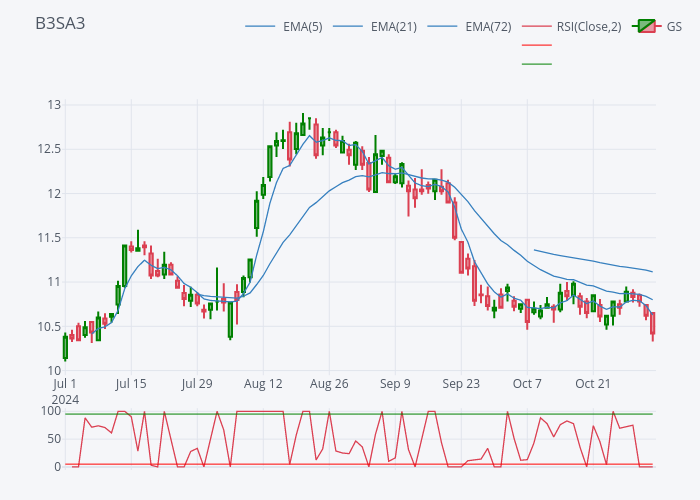

In [ ]:
ohlc = yf.download(tickers= ativo+'.SA', period = periodo , auto_adjust=True, progress = False )

qf=cf.QuantFig(ohlc[-90:] , title= x ,legend='top',name='GS',up_color='green', down_color='red')
#qf.add_bollinger_bands(periods=20, boll_std=2, colors=['cyan','grey'], fill=True)
qf.add_ema(periods=5)
qf.add_ema(periods=21)
qf.add_ema(periods=72)
qf.add_rsi(periods=2,color='red',rsi_upper=95,rsi_lower=5,showbands=True)

fig = qf.figure(title=ativo )
fig.update_xaxes(
    rangebreaks=[dict(bounds=["sat", "mon"])])
fig.show()

**informações dos trades**

In [ ]:
for x in range(len(lista_ifr)):
  print("\n******",retornos[x][0],"(retornos) ********")
  print('resumo dos retornos das operações:')
  print(pd.Series(retornos[x][1]).describe()  );


****** B3SA3 (retornos) ********
resumo dos retornos das operações:
count    13.000000
mean     -0.005729
std       0.029075
min      -0.057642
25%      -0.018784
50%      -0.003972
75%       0.018927
max       0.034453
dtype: float64

****** BBDC3 (retornos) ********
resumo dos retornos das operações:
count    13.000000
mean     -0.015447
std       0.028536
min      -0.089528
25%      -0.017905
50%      -0.012810
75%       0.000846
max       0.025845
dtype: float64

****** BBDC4 (retornos) ********
resumo dos retornos das operações:
count    14.000000
mean     -0.011168
std       0.037065
min      -0.117412
25%      -0.018794
50%       0.002616
75%       0.011809
max       0.021739
dtype: float64

****** BPAC11 (retornos) ********
resumo dos retornos das operações:
count    16.000000
mean      0.004285
std       0.034077
min      -0.078414
25%      -0.018243
50%       0.006724
75%       0.022175
max       0.065708
dtype: float64

****** [] (retornos) ********
resumo dos retornos das 

In [ ]:
out

[['B3SA3',
  ['entrada em 11/11/2022 e saida em 24/11/2022 durou 8 dias e variou -5.135%',
   'entrada em 13/12/2022 e saida em 15/12/2022 durou 2 dias e variou -0.836%',
   'entrada em 08/02/2023 e saida em 14/02/2023 durou 4 dias e variou 0.36%',
   'entrada em 24/02/2023 e saida em 03/03/2023 durou 5 dias e variou -0.397%',
   'entrada em 24/03/2023 e saida em 29/03/2023 durou 3 dias e variou 2.126%',
   'entrada em 10/08/2023 e saida em 23/08/2023 durou 9 dias e variou -3.302%',
   'entrada em 01/09/2023 e saida em 12/09/2023 durou 6 dias e variou 0.491%',
   'entrada em 27/09/2023 e saida em 29/09/2023 durou 2 dias e variou 3.445%',
   'entrada em 05/01/2024 e saida em 09/01/2024 durou 2 dias e variou 2.93%',
   'entrada em 31/01/2024 e saida em 02/02/2024 durou 2 dias e variou 1.893%',
   'entrada em 17/04/2024 e saida em 23/04/2024 durou 4 dias e variou -1.878%',
   'entrada em 23/05/2024 e saida em 07/06/2024 durou 10 dias e variou -1.38%',
   'entrada em 23/09/2024 e saida em 

In [ ]:
import talib
talib.RSI(ohlc["Close"] , 2)

Date
2022-11-01           NaN
2022-11-03           NaN
2022-11-04    100.000000
2022-11-07     44.444540
2022-11-08     49.999957
                 ...    
2024-10-28     81.086284
2024-10-29     56.851343
2024-10-30     37.948227
2024-10-31     12.131806
2024-11-01      4.491987
Length: 503, dtype: float64

In [ ]:
rsi(ohlc["Close"])

Date
2022-11-01       NaN
2022-11-03    100.00
2022-11-04    100.00
2022-11-07     36.84
2022-11-08     43.93
               ...  
2024-10-28     81.09
2024-10-29     56.85
2024-10-30     37.95
2024-10-31     12.13
2024-11-01      4.49
Name: rsi, Length: 503, dtype: float64

In [ ]:
import quantstats as qs

help(qs.reports.full)

Help on function full in module quantstats.reports:

full(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=True, **kwargs)



In [ ]:
ohlc

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-01,13.941707,14.331555,13.644680,14.034528,43955100
2022-11-03,13.876730,14.387246,13.765345,14.275861,38761200
2022-11-04,14.387245,14.832785,14.322271,14.480066,35021800
2022-11-07,14.303709,14.480069,14.108784,14.201606,63757400
2022-11-08,14.164477,14.535760,14.080938,14.229451,62326600
...,...,...,...,...,...
2024-10-28,10.780000,10.950000,10.770000,10.890000,29203800
2024-10-29,10.880000,10.920000,10.770000,10.830000,26229700
2024-10-30,10.850000,10.870000,10.720000,10.780000,26539600


In [ ]:
retorno_estrategia

Date
2022-11-01    0.0
2022-11-03    0.0
2022-11-04    0.0
2022-11-07   -0.0
2022-11-08    0.0
             ... 
2024-10-28    0.0
2024-10-29   -0.0
2024-10-30   -0.0
2024-10-31   -0.0
2024-11-01   -0.0
Name: retorno_estrategia, Length: 503, dtype: float64

                           Strategy
-------------------------  ----------
Start Period               2022-11-01
End Period                 2024-11-01
Risk-Free Rate             0.0%
Time in Market             13.0%

Cumulative Return          -5.27%
CAGR﹪                     -1.85%

Sharpe                     -0.19
Prob. Sharpe Ratio         39.49%
Smart Sharpe               -0.17
Sortino                    -0.26
Smart Sortino              -0.23
Sortino/√2                 -0.18
Smart Sortino/√2           -0.16
Omega                      0.92

Max Drawdown               -11.72%
Longest DD Days            688
Volatility (ann.)          11.12%
Calmar                     -0.16
Skew                       -0.64
Kurtosis                   27.84

Expected Daily %           -0.01%
Expected Monthly %         -0.22%
Expected Yearly %          -1.79%
Kelly Criterion            -4.27%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.16%
Expected Shortfall (cVaR)  -1.16%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-12-15,2023-08-17,2024-11-01,688,-11.716365,-9.218390
2,2022-11-14,2022-11-17,2022-11-23,10,-7.392677,-5.643882


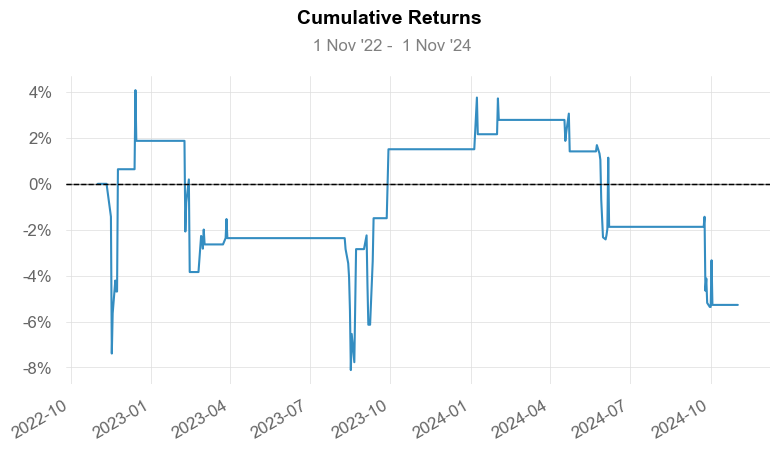

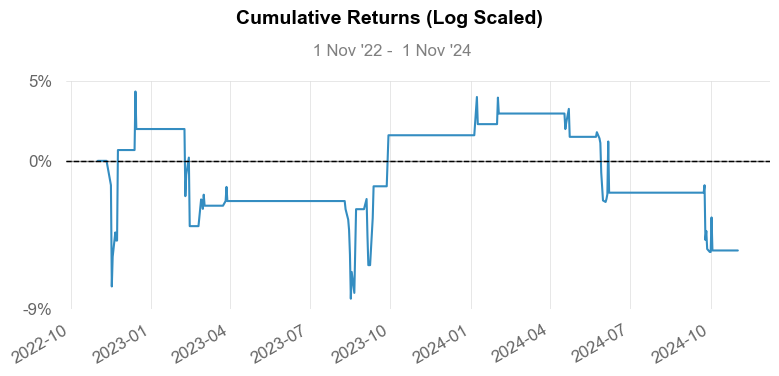

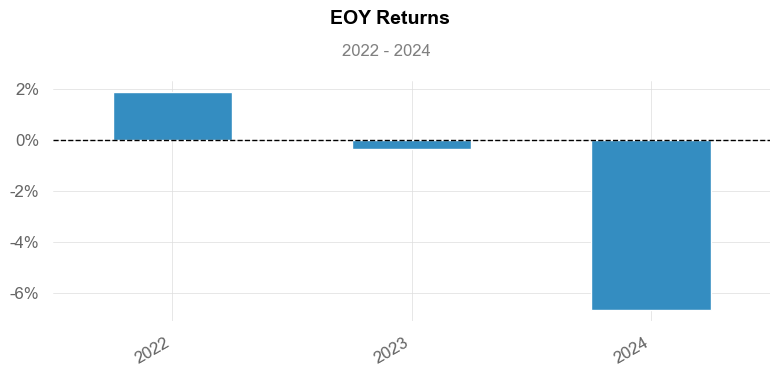

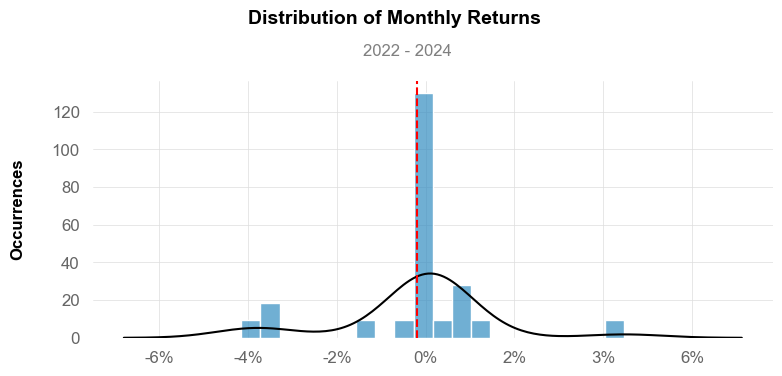

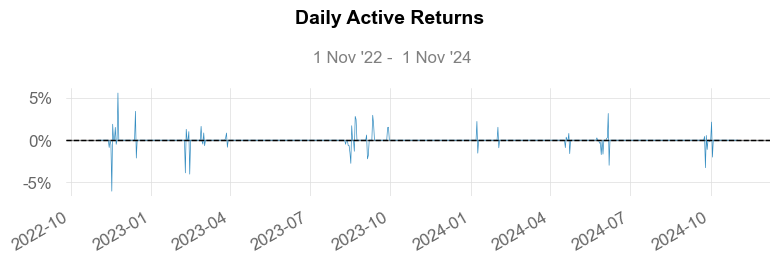

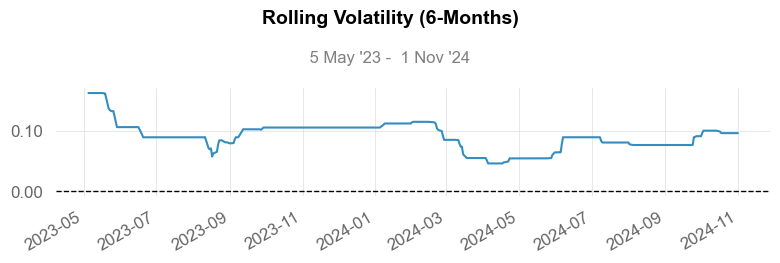

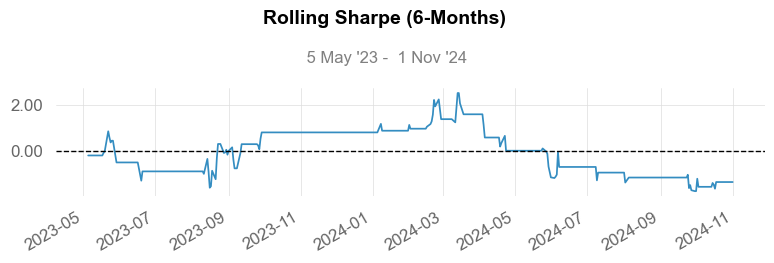

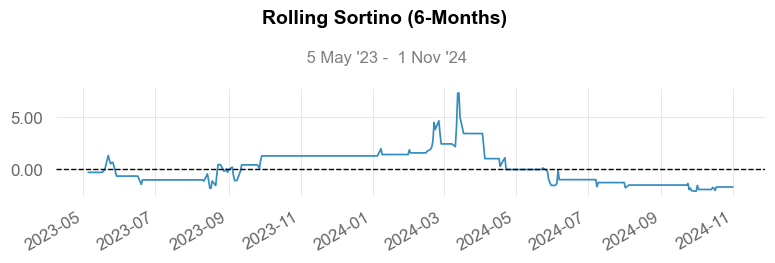

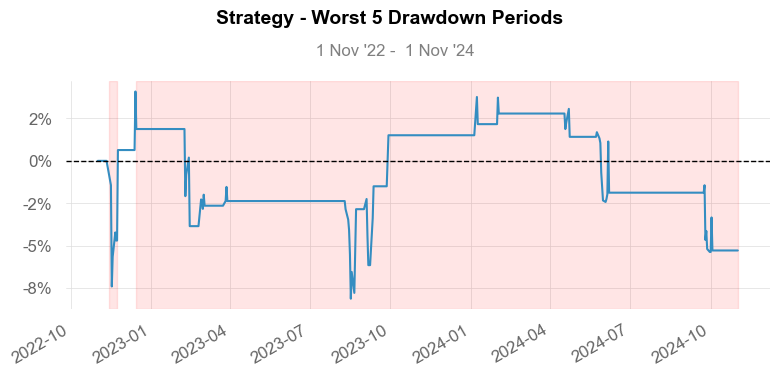

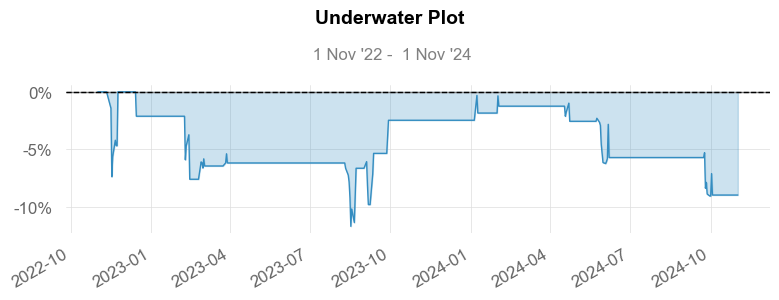

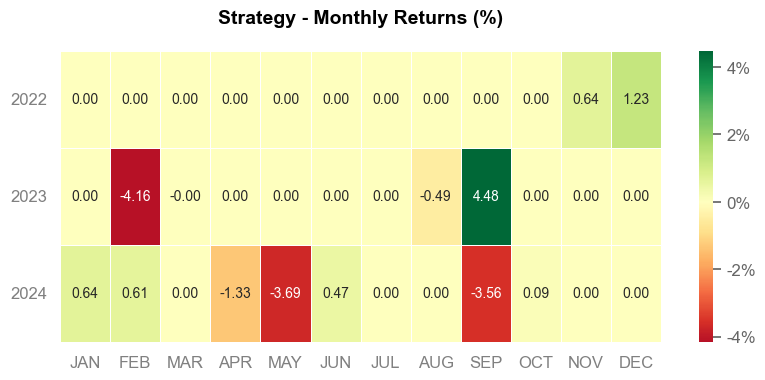

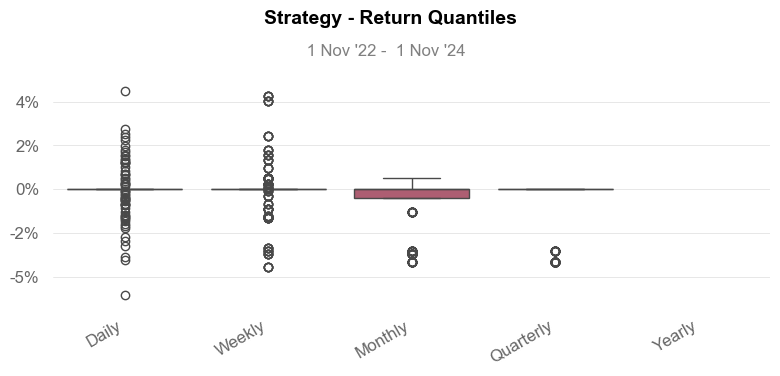

In [ ]:
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

qs.reports.full(retorno_estrategia)